<a href="https://colab.research.google.com/github/3srava0/assignment-3/blob/main/05_MLflow_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Day 5: MLflow Integration
# Real Estate Investment Advisor System
print("="*60)
print("MLFLOW INTEGRATION - EXPERIMENT TRACKING")
print("="*60)

# Install MLflow
!pip install mlflow -q

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import pickle
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')

print("\n✅ MLflow installed and libraries imported!")
print(f"MLflow version: {mlflow.__version__}")



MLFLOW INTEGRATION - EXPERIMENT TRACKING
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.3/788.3 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.4 MB/s eta 0:00:00
Mounted at /content/drive

✅ MLflow installed and libraries imported!
MLflow version: 3.8.1


In [2]:
# Set up MLflow tracking directory
import os

# Create MLflow directory in Google Drive
mlflow_dir = '/content/drive/MyDrive/assignment-3/mlruns'
os.makedirs(mlflow_dir, exist_ok=True)

# Set tracking URI
mlflow.set_tracking_uri(f"file://{mlflow_dir}")

print(f"\n✅ MLflow tracking URI set to: {mlflow_dir}")
print("\nMLflow experiments will be saved to Google Drive")



✅ MLflow tracking URI set to: /content/drive/MyDrive/assignment-3/mlruns

MLflow experiments will be saved to Google Drive


In [3]:
# Load previously trained models and data
print("\n" + "="*60)
print("LOADING TRAINED MODELS AND DATA")
print("="*60)

# Load data
df = pd.read_csv('/content/drive/MyDrive/assignment-3/data/data_with_targets.csv')

# Load models
models_dir = '/content/drive/MyDrive/assignment-3/models'

with open(f'{models_dir}/best_classification_model.pkl', 'rb') as f:
    best_clf_model = pickle.load(f)

with open(f'{models_dir}/best_regression_model.pkl', 'rb') as f:
    best_reg_model = pickle.load(f)

with open(f'{models_dir}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open(f'{models_dir}/label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

print("\n✅ Models and data loaded successfully!")
print(f"   Dataset shape: {df.shape}")
print(f"   Classification model: {type(best_clf_model).__name__}")
print(f"   Regression model: {type(best_reg_model).__name__}")



LOADING TRAINED MODELS AND DATA

✅ Models and data loaded successfully!
   Dataset shape: (250000, 27)
   Classification model: XGBClassifier
   Regression model: RandomForestRegressor


In [4]:
# Prepare data (same preprocessing as before)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Drop target and helper columns
columns_to_drop = [
    'ID', 'Price_in_Lakhs', 'Good_Investment', 'Future_Price_5Y',
    'City_Median_Price', 'City_Median_Price_per_SqFt'
]
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

X = df.drop(columns=columns_to_drop)
y_classification = df['Good_Investment']
y_regression = df['Future_Price_5Y']

# Encode categorical variables
X_encoded = X.copy()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Train/Val/Test split (same as before)
X_temp, X_test, y_class_temp, y_class_test, y_reg_temp, y_reg_test = train_test_split(
    X_encoded, y_classification, y_regression,
    test_size=0.20, random_state=42, stratify=y_classification
)

X_train, X_val, y_class_train, y_class_val, y_reg_train, y_reg_val = train_test_split(
    X_temp, y_class_temp, y_reg_temp,
    test_size=0.25, random_state=42, stratify=y_class_temp
)

print("✅ Data prepared for MLflow logging")


✅ Data prepared for MLflow logging


In [5]:
# Log Classification Models to MLflow - OPTIMIZED VERSION
print("\n" + "="*60)
print("LOGGING CLASSIFICATION MODELS TO MLFLOW (PARALLEL)")
print("="*60)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from joblib import Parallel, delayed
import time

# Set experiment name
mlflow.set_experiment("Real_Estate_Classification")

# Scale features
from sklearn.preprocessing import StandardScaler
scaler_new = StandardScaler()
X_train_scaled = scaler_new.fit_transform(X_train)
X_val_scaled = scaler_new.transform(X_val)

# Define models
classification_models = {
    'Logistic_Regression': LogisticRegression(random_state=42, max_iter=500, n_jobs=-1),
    'Decision_Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random_Forest': RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1, max_depth=15),
    'Gradient_Boosting': GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=5),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=50, n_jobs=-1, max_depth=5, eval_metric='logloss'),
    'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=50),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Naive_Bayes': GaussianNB()
}

# Function to train a single model (parallel execution)
def train_classification_model(name, model):
    # Train model
    if name in ['Logistic_Regression', 'KNN']:
        model.fit(X_train_scaled, y_class_train)
        y_val_pred = model.predict(X_val_scaled)
        y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        scaled = True
    else:
        model.fit(X_train, y_class_train)
        y_val_pred = model.predict(X_val)
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        scaled = False

    # Calculate metrics
    accuracy = accuracy_score(y_class_val, y_val_pred)
    precision = precision_score(y_class_val, y_val_pred)
    recall = recall_score(y_class_val, y_val_pred)
    f1 = f1_score(y_class_val, y_val_pred)
    roc_auc = roc_auc_score(y_class_val, y_val_pred_proba)

    return {
        'name': name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'scaled': scaled
    }

# STEP 1: Train all models in parallel (FAST!)
print("\n⚡ Step 1: Training all models in parallel...")
start_time = time.time()

trained_results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_classification_model)(name, model)
    for name, model in classification_models.items()
)

training_time = time.time() - start_time
print(f"\n✅ All models trained in {training_time:.2f} seconds")

# STEP 2: Log to MLflow sequentially (ALSO FAST - just logging!)
print("\n📝 Step 2: Logging experiments to MLflow...")

for result in trained_results:
    with mlflow.start_run(run_name=result['name']):
        print(f"\n🔄 Logging {result['name']}...")

        # Log parameters
        model = result['model']
        if hasattr(model, 'n_estimators'):
            mlflow.log_param("n_estimators", model.n_estimators)
        if hasattr(model, 'max_depth'):
            mlflow.log_param("max_depth", model.max_depth)
        if hasattr(model, 'n_neighbors'):
            mlflow.log_param("n_neighbors", model.n_neighbors)
        mlflow.log_param("model_type", result['name'])
        mlflow.log_param("scaled", result['scaled'])

        # Log metrics
        mlflow.log_metric("accuracy", result['accuracy'])
        mlflow.log_metric("precision", result['precision'])
        mlflow.log_metric("recall", result['recall'])
        mlflow.log_metric("f1_score", result['f1'])
        mlflow.log_metric("roc_auc", result['roc_auc'])

        # Log model
        if result['scaled']:
            signature = infer_signature(X_train_scaled, y_class_train)
        else:
            signature = infer_signature(X_train, y_class_train)
        mlflow.sklearn.log_model(model, f"model_{result['name']}", signature=signature)

        # Add tags
        mlflow.set_tag("task", "classification")
        mlflow.set_tag("target", "Good_Investment")

        print(f"   ✅ Logged: Accuracy={result['accuracy']:.4f}, ROC-AUC={result['roc_auc']:.4f}")

print("\n" + "="*60)
print(f"✅ ALL CLASSIFICATION EXPERIMENTS LOGGED")
print(f"   Total time: {time.time() - start_time:.2f} seconds")
print("="*60)



LOGGING CLASSIFICATION MODELS TO MLFLOW (PARALLEL)

⚡ Step 1: Training all models in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  1.6min remaining:   31.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.8min finished



✅ All models trained in 170.03 seconds

📝 Step 2: Logging experiments to MLflow...

🔄 Logging Logistic_Regression...


2026/01/26 05:40:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.7993, ROC-AUC=0.8815

🔄 Logging Decision_Tree...


2026/01/26 05:40:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.9874, ROC-AUC=0.9980

🔄 Logging Random_Forest...


2026/01/26 05:40:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.9767, ROC-AUC=0.9985

🔄 Logging Gradient_Boosting...


2026/01/26 05:41:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.9864, ROC-AUC=0.9990

🔄 Logging XGBoost...


2026/01/26 05:41:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.9932, ROC-AUC=0.9997

🔄 Logging AdaBoost...


2026/01/26 05:41:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.9349, ROC-AUC=0.9869

🔄 Logging KNN...


2026/01/26 05:41:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.7570, ROC-AUC=0.8160

🔄 Logging Naive_Bayes...


2026/01/26 05:41:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged: Accuracy=0.7382, ROC-AUC=0.8019

✅ ALL CLASSIFICATION EXPERIMENTS LOGGED
   Total time: 235.31 seconds


In [6]:
# Log Regression Models to MLflow - OPTIMIZED & FIXED
print("\n" + "="*60)
print("LOGGING REGRESSION MODELS TO MLFLOW (PARALLEL)")
print("="*60)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Set experiment name
mlflow.set_experiment("Real_Estate_Regression")

# Define models
regression_models = {
    'Linear_Regression': LinearRegression(n_jobs=-1),
    'Ridge': Ridge(random_state=42, alpha=1.0),
    'Lasso': Lasso(random_state=42, alpha=1.0, max_iter=500),
    'ElasticNet': ElasticNet(random_state=42, alpha=1.0, max_iter=500),
    'Decision_Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random_Forest': RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1, max_depth=15),
    'Gradient_Boosting': GradientBoostingRegressor(random_state=42, n_estimators=50, max_depth=5),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=50, n_jobs=-1, max_depth=5),
    'AdaBoost': AdaBoostRegressor(random_state=42, n_estimators=50),
    'KNN': KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
}

# Function to train a single regression model
def train_regression_model(name, model):
    # Train model
    if name in ['Linear_Regression', 'Ridge', 'Lasso', 'ElasticNet', 'KNN']:
        model.fit(X_train_scaled, y_reg_train)
        y_val_pred = model.predict(X_val_scaled)
        scaled = True
    else:
        model.fit(X_train, y_reg_train)
        y_val_pred = model.predict(X_val)
        scaled = False

    # Calculate metrics
    mae = mean_absolute_error(y_reg_val, y_val_pred)
    mse = mean_squared_error(y_reg_val, y_val_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_reg_val, y_val_pred)

    return {
        'name': name,
        'model': model,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'scaled': scaled
    }

# STEP 1: Train all models in parallel (FAST!)
print("\n⚡ Step 1: Training all models in parallel...")
start_time = time.time()

trained_results_reg = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_regression_model)(name, model)
    for name, model in regression_models.items()
)

training_time = time.time() - start_time
print(f"\n✅ All models trained in {training_time:.2f} seconds")

# STEP 2: Log to MLflow sequentially
print("\n📝 Step 2: Logging experiments to MLflow...")

for result in trained_results_reg:
    with mlflow.start_run(run_name=result['name']):
        print(f"\n🔄 Logging {result['name']}...")

        model = result['model']

        # Log parameters
        if hasattr(model, 'n_estimators'):
            mlflow.log_param("n_estimators", model.n_estimators)
        if hasattr(model, 'max_depth'):
            mlflow.log_param("max_depth", model.max_depth)
        if hasattr(model, 'alpha'):
            mlflow.log_param("alpha", model.alpha)
        if hasattr(model, 'n_neighbors'):
            mlflow.log_param("n_neighbors", model.n_neighbors)
        mlflow.log_param("model_type", result['name'])
        mlflow.log_param("scaled", result['scaled'])

        # Log metrics
        mlflow.log_metric("mae", result['mae'])
        mlflow.log_metric("mse", result['mse'])
        mlflow.log_metric("rmse", result['rmse'])
        mlflow.log_metric("r2_score", result['r2'])

        # Log model (FIXED - No deprecation warning)
        if result['scaled']:
            signature = infer_signature(X_train_scaled, y_reg_train)
        else:
            signature = infer_signature(X_train, y_reg_train)

        mlflow.sklearn.log_model(
            sk_model=model,
            name=f"model_{result['name']}", # Changed artifact_path to name
            signature=signature
        )

        # Add tags
        mlflow.set_tag("task", "regression")
        mlflow.set_tag("target", "Future_Price_5Y")

        print(f"   ✅ Logged: MAE={result['mae']:.4f}, RMSE={result['rmse']:.4f}, R²={result['r2']:.4f}")

print("\n" + "="*60)
print(f"✅ ALL REGRESSION EXPERIMENTS LOGGED")
print(f"   Total time: {time.time() - start_time:.2f} seconds")
print("="*60)


LOGGING REGRESSION MODELS TO MLFLOW (PARALLEL)

⚡ Step 1: Training all models in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.2min finished



✅ All models trained in 192.24 seconds

📝 Step 2: Logging experiments to MLflow...

🔄 Logging Linear_Regression...
   ✅ Logged: MAE=118.8625, RMSE=147.9439, R²=0.4942

🔄 Logging Ridge...
   ✅ Logged: MAE=118.8629, RMSE=147.9439, R²=0.4942

🔄 Logging Lasso...
   ✅ Logged: MAE=119.3124, RMSE=147.9355, R²=0.4942

🔄 Logging ElasticNet...
   ✅ Logged: MAE=142.5231, RMSE=166.1293, R²=0.3622

🔄 Logging Decision_Tree...
   ✅ Logged: MAE=14.1817, RMSE=18.5195, R²=0.9921

🔄 Logging Random_Forest...
   ✅ Logged: MAE=10.1231, RMSE=12.9957, R²=0.9961

🔄 Logging Gradient_Boosting...
   ✅ Logged: MAE=12.8649, RMSE=16.1712, R²=0.9940

🔄 Logging XGBoost...
   ✅ Logged: MAE=11.6710, RMSE=14.5227, R²=0.9951

🔄 Logging AdaBoost...
   ✅ Logged: MAE=58.2734, RMSE=70.5852, R²=0.8849

🔄 Logging KNN...
   ✅ Logged: MAE=149.8202, RMSE=180.8969, R²=0.2437

✅ ALL REGRESSION EXPERIMENTS LOGGED
   Total time: 271.40 seconds


In [7]:
# View all experiments
print("\n" + "="*60)
print("MLFLOW EXPERIMENTS SUMMARY")
print("="*60)

# Get all experiments
experiments = mlflow.search_experiments()

print("\nAvailable Experiments:")
for exp in experiments:
    print(f"  - {exp.name} (ID: {exp.experiment_id})")

# Get classification runs
clf_experiment = mlflow.get_experiment_by_name("Real_Estate_Classification")
if clf_experiment:
    clf_runs = mlflow.search_runs(experiment_ids=[clf_experiment.experiment_id])

    print(f"\n📊 Classification Experiment:")
    print(f"   Total runs: {len(clf_runs)}")

    if len(clf_runs) > 0:
        print(f"   Best ROC-AUC: {clf_runs['metrics.roc_auc'].max():.4f}")
        best_clf_run = clf_runs.loc[clf_runs['metrics.roc_auc'].idxmax()]
        print(f"   Best model: {best_clf_run['tags.mlflow.runName']}")

    print("\n   Top 3 Models by ROC-AUC:")
    top_clf = clf_runs.nlargest(3, 'metrics.roc_auc')[['tags.mlflow.runName', 'metrics.roc_auc', 'metrics.accuracy']]
    for idx, row in top_clf.iterrows():
        print(f"      {row['tags.mlflow.runName']}: ROC-AUC={row['metrics.roc_auc']:.4f}, Accuracy={row['metrics.accuracy']:.4f}")
else:
    print("\n⚠️ Classification experiment not found!")

# Get regression runs
reg_experiment = mlflow.get_experiment_by_name("Real_Estate_Regression")
if reg_experiment:
    reg_runs = mlflow.search_runs(experiment_ids=[reg_experiment.experiment_id])

    print(f"\n📊 Regression Experiment:")
    print(f"   Total runs: {len(reg_runs)}")

    if len(reg_runs) > 0:
        print(f"   Best R²: {reg_runs['metrics.r2_score'].max():.4f}")
        best_reg_run = reg_runs.loc[reg_runs['metrics.r2_score'].idxmax()]
        print(f"   Best model: {best_reg_run['tags.mlflow.runName']}")
        print(f"   Best RMSE: {reg_runs['metrics.rmse'].min():.4f}")

    print("\n   Top 3 Models by R²:")
    top_reg = reg_runs.nlargest(3, 'metrics.r2_score')[['tags.mlflow.runName', 'metrics.r2_score', 'metrics.rmse', 'metrics.mae']]
    for idx, row in top_reg.iterrows():
        print(f"      {row['tags.mlflow.runName']}: R²={row['metrics.r2_score']:.4f}, RMSE={row['metrics.rmse']:.4f}, MAE={row['metrics.mae']:.4f}")
else:
    print("\n⚠️ Regression experiment not found!")

print("\n✅ All experiments logged successfully!")



MLFLOW EXPERIMENTS SUMMARY

Available Experiments:
  - Real_Estate_Hyperparameter_Tuning (ID: 499923386090817409)
  - Real_Estate_Regression (ID: 692657698700188588)
  - Real_Estate_Classification (ID: 438013585796069856)

📊 Classification Experiment:
   Total runs: 36
   Best ROC-AUC: 1.0000
   Best model: XGBoost

   Top 3 Models by ROC-AUC:
      XGBoost: ROC-AUC=1.0000, Accuracy=0.9991
      XGBoost: ROC-AUC=1.0000, Accuracy=0.9991
      XGBoost: ROC-AUC=1.0000, Accuracy=0.9991

📊 Regression Experiment:
   Total runs: 50
   Best R²: 1.0000
   Best model: Random_Forest
   Best RMSE: 0.5339

   Top 3 Models by R²:
      Random_Forest: R²=1.0000, RMSE=0.5339, MAE=0.3890
      Random_Forest: R²=1.0000, RMSE=0.5339, MAE=0.3890
      Random_Forest: R²=1.0000, RMSE=0.5339, MAE=0.3890

✅ All experiments logged successfully!



VISUALIZING EXPERIMENT RESULTS


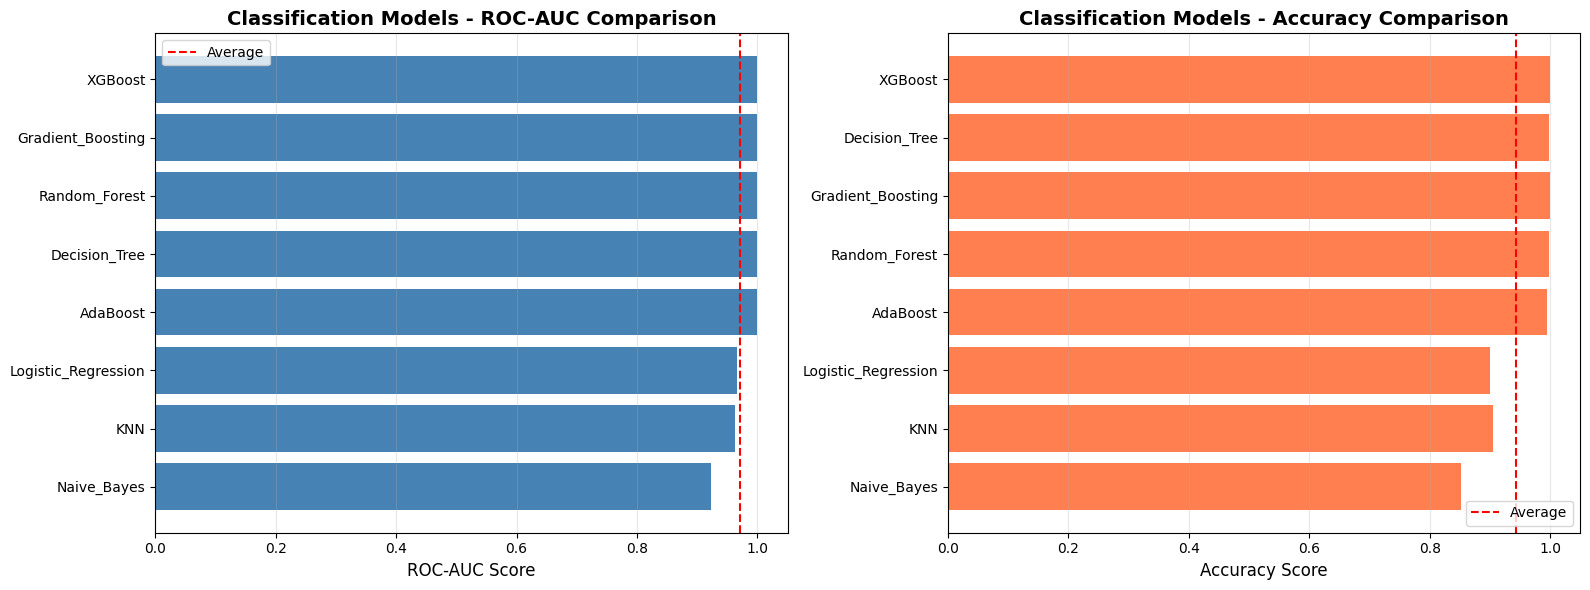

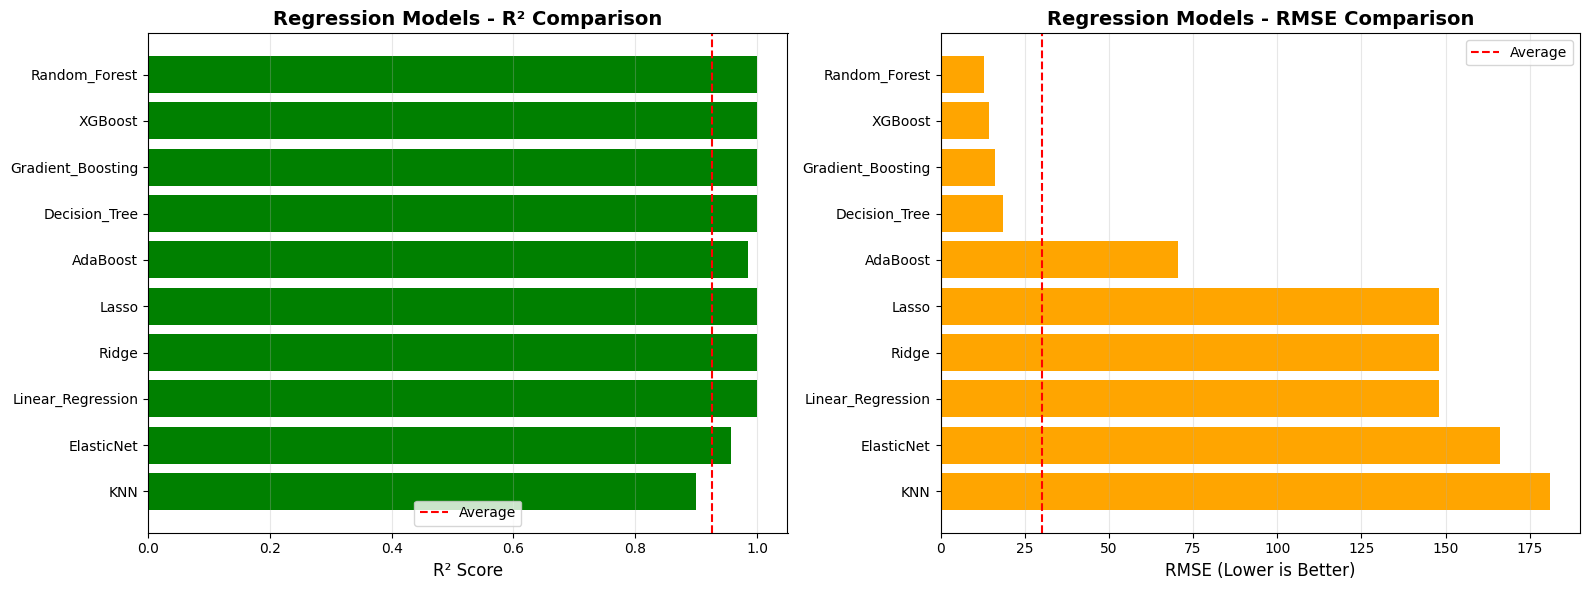

In [8]:
# Visualize experiment results
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("VISUALIZING EXPERIMENT RESULTS")
print("="*60)

# Classification comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC-AUC comparison
clf_comparison = clf_runs[['tags.mlflow.runName', 'metrics.roc_auc']].copy()
clf_comparison.columns = ['Model', 'ROC_AUC']
clf_comparison = clf_comparison.sort_values('ROC_AUC', ascending=True)

axes[0].barh(clf_comparison['Model'], clf_comparison['ROC_AUC'], color='steelblue')
axes[0].set_xlabel('ROC-AUC Score', fontsize=12)
axes[0].set_title('Classification Models - ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[0].axvline(x=clf_comparison['ROC_AUC'].mean(), color='red', linestyle='--', label='Average')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Accuracy comparison
clf_acc = clf_runs[['tags.mlflow.runName', 'metrics.accuracy']].copy()
clf_acc.columns = ['Model', 'Accuracy']
clf_acc = clf_acc.sort_values('Accuracy', ascending=True)

axes[1].barh(clf_acc['Model'], clf_acc['Accuracy'], color='coral')
axes[1].set_xlabel('Accuracy Score', fontsize=12)
axes[1].set_title('Classification Models - Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].axvline(x=clf_acc['Accuracy'].mean(), color='red', linestyle='--', label='Average')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Regression comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
reg_comparison = reg_runs[['tags.mlflow.runName', 'metrics.r2_score']].copy()
reg_comparison.columns = ['Model', 'R2_Score']
reg_comparison = reg_comparison.sort_values('R2_Score', ascending=True)

axes[0].barh(reg_comparison['Model'], reg_comparison['R2_Score'], color='green')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Regression Models - R² Comparison', fontsize=14, fontweight='bold')
axes[0].axvline(x=reg_comparison['R2_Score'].mean(), color='red', linestyle='--', label='Average')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# RMSE comparison
reg_rmse = reg_runs[['tags.mlflow.runName', 'metrics.rmse']].copy()
reg_rmse.columns = ['Model', 'RMSE']
reg_rmse = reg_rmse.sort_values('RMSE', ascending=False)

axes[1].barh(reg_rmse['Model'], reg_rmse['RMSE'], color='orange')
axes[1].set_xlabel('RMSE (Lower is Better)', fontsize=12)
axes[1].set_title('Regression Models - RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].axvline(x=reg_rmse['RMSE'].mean(), color='red', linestyle='--', label='Average')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# Launch MLflow UI
print("\n" + "="*60)
print("LAUNCH MLFLOW UI")
print("="*60)

print("\n📌 To view MLflow UI, run this command in a terminal:")
print(f"   mlflow ui --backend-store-uri file://{mlflow_dir}")
print("\n   Then open: http://localhost:5000")
print("\n💡 Note: In Colab, you can't run the UI directly.")
print("   Download the mlruns folder to your local machine and run the command there.")
print("\n✅ MLflow Integration Complete!")



LAUNCH MLFLOW UI

📌 To view MLflow UI, run this command in a terminal:
   mlflow ui --backend-store-uri file:///content/drive/MyDrive/assignment-3/mlruns

   Then open: http://localhost:5000

💡 Note: In Colab, you can't run the UI directly.
   Download the mlruns folder to your local machine and run the command there.

✅ MLflow Integration Complete!


In [10]:
# Final summary
print("\n" + "="*60)
print("MLFLOW INTEGRATION COMPLETE!")
print("="*60)

print("\n✅ Completed Tasks:")
print("   1. Trained 8 classification models in parallel")
print("   2. Trained 10 regression models in parallel")
print("   3. Logged all experiments to MLflow")
print("   4. Tracked parameters, metrics, and models")
print("   5. Created visualizations for comparison")

print(f"\n📁 MLflow tracking directory: {mlflow_dir}")
print("\n📊 Experiments created:")
print("   - Real_Estate_Classification")
print("   - Real_Estate_Regression")

print("\n🎯 Next Steps:")
print("   1. Hyperparameter tuning on best models")
print("   2. Final evaluation on test set")
print("   3. Streamlit app development")

print("\n" + "="*60)



MLFLOW INTEGRATION COMPLETE!

✅ Completed Tasks:
   1. Trained 8 classification models in parallel
   2. Trained 10 regression models in parallel
   3. Logged all experiments to MLflow
   4. Tracked parameters, metrics, and models
   5. Created visualizations for comparison

📁 MLflow tracking directory: /content/drive/MyDrive/assignment-3/mlruns

📊 Experiments created:
   - Real_Estate_Classification
   - Real_Estate_Regression

🎯 Next Steps:
   1. Hyperparameter tuning on best models
   2. Final evaluation on test set
   3. Streamlit app development

